In [35]:
#imports
import collections
from math import sqrt
import numpy as np
import scipy.stats as stats
import pandas as pd
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
# Connect to DB and read all data
conn = sqlite3.connect('bee_sightings_native.sqlite')
bee_data = pd.read_sql('SELECT * from bee_sightings', conn)
bee_data.replace('', np.nan, inplace=True)
bee_data.head()

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
0,21041,Yellow-faced bumble bee,2017-08-05 00:00:00.000000,45.524403,-122.637095,None,1,None
1,20632,Yellow-faced bumble bee,2017-08-08 00:00:00.000000,45.494031,-122.427821,Joe Pye weed,1,Non-native
2,20423,Obscure bumble bee,2017-08-06 00:00:00.000000,45.584405,-122.723538,None,1,None
3,20263,Bumble bee,2017-08-03 00:00:00.000000,45.494263,-122.427542,Aster Douglasii,1,Native
4,19923,Bumble bee,2017-07-27 00:00:00.000000,45.539996,-122.571588,NaN,1,None


In [3]:
# Most popular plant? 
    # Which plant saw the most visits? 
        # Ceanothus, blackberry, rhododendron
    #The largest diversity of visitors.
        # Blackberry 
    
# Plot bee species on x-axis, flower species on y-axis. Any cool clustering happening? Color bee species differently
  #to see if bee species cluster around certain plant species
    
# Generalization ratio: calculate the variance in visits for a particular species across all flower species. Fewer
  #the species, less the variance, and thus the more specialist a species might be.



130


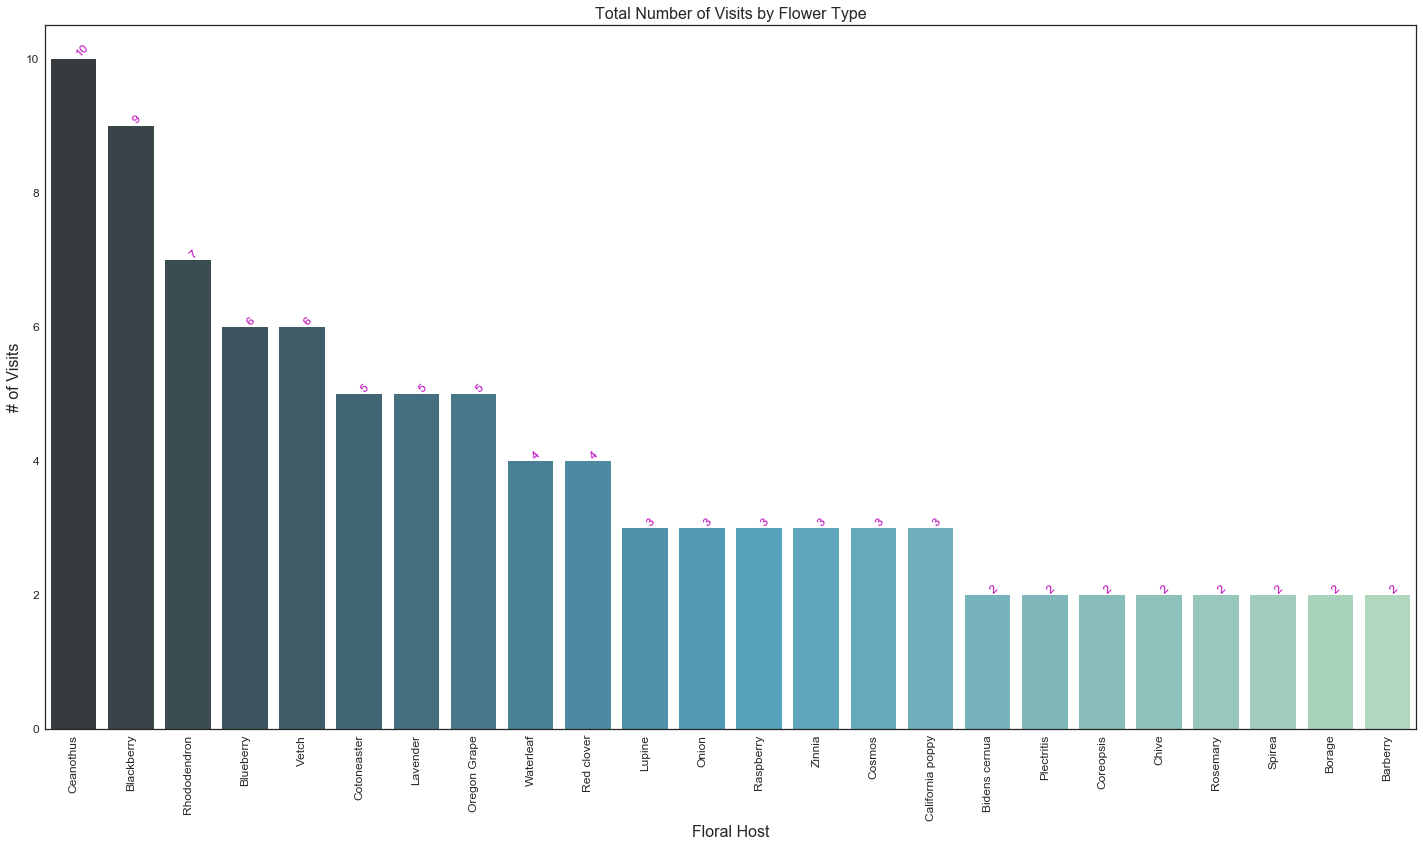

In [125]:
# Query for total abundance/count of by plant species name within verified sightings
verified_sightings = bee_data[(bee_data.sightingstatus_id == 2) & bee_data['floral_host'].notnull()]
print(len(verified_sightings))
numVisits = pd.DataFrame(verified_sightings.groupby(['floral_host']).size())
numVisits.columns = ['Count']
numVisits = numVisits[numVisits['Count'] > 1]
numVisits = numVisits.sort_values(['Count'], ascending=False)

# Create a figure
plt.figure(1, figsize=(20, 12))
# Plot barchart with DataFrame index as x values
#purples = sns.cubehelix_palette(24, light=1, reverse=True, gamma=1.5)
ax = sns.barplot(numVisits.index, numVisits.Count, palette=sns.color_palette("GnBu_d", n_colors=24))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax.set_xlabel('Floral Host', fontsize=16)
ax.set_ylabel('# of Visits', fontsize=16)
ax.set_title("Total Number of Visits by Flower Type", fontsize=16)
ax.yaxis.grid(False)
# add proper Visits values as x labels
ax.set_xticklabels(numVisits.index, size=12)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(numVisits['Count'].iteritems()):
    ax.text(i, v[1], '{:,}'.format(v[1]), color='m', va='bottom', rotation=45, size=12)
plt.tight_layout()
plt.show()
#plt.savefig("VisitsByFlowerType.png")

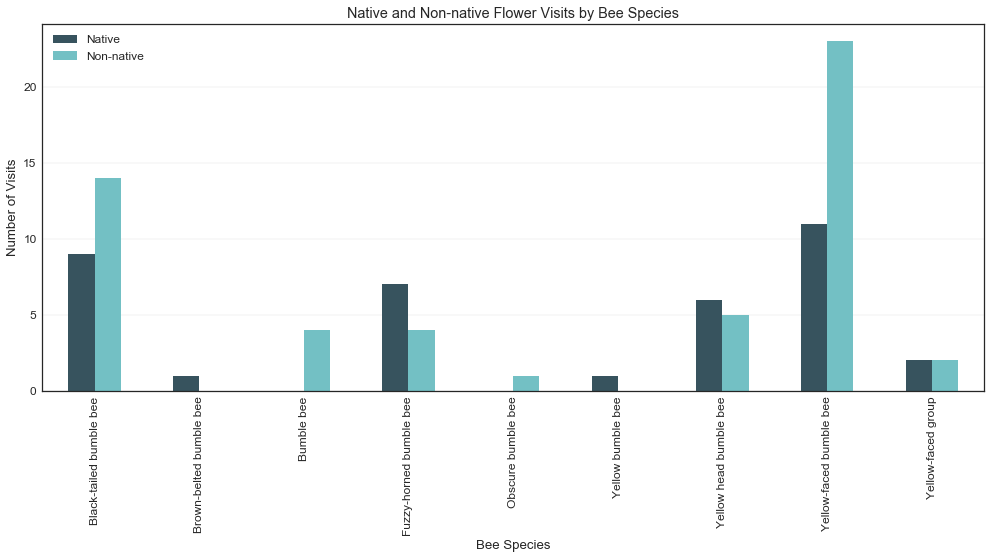

In [149]:
# Plot total bee species diversity on the y-axis, and Native, Non-native on the x-axis.
verified_sightings
nativeNon = pd.DataFrame(verified_sightings.groupby(['common_name', 'native_status']).size())
nativeNon.columns = ['Count']
unstacked = nativeNon.unstack(level=1)

colormap = []
for color in sns.color_palette("GnBu_d"):
    for value in color:
        #value *= 255
        colormap.append(value)
two_color = [(float(colormap[0]), float(colormap[1]), float(colormap[2])), (float(colormap[12]), float(colormap[13]), float(colormap[14]))]
graph = nativeNon.unstack(level=1).plot(kind='bar', subplots=False, figsize=(14,8), color=two_color)
plt.title("Native and Non-native Flower Visits by Bee Species")
plt.xlabel("Bee Species")
plt.ylabel("Number of Visits")
graph.yaxis.grid(which="major", linewidth=0.25)
plt.legend(['Native', 'Non-native'], loc='upper left')
plt.tight_layout()

In [6]:
verified_sightings

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
12,18882,Yellow-faced bumble bee,2017-07-07 00:00:00.000000,45.489315,-122.507107,Daisy,2,NaN
22,18595,White-shouldered bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Vetch,2,None
23,18593,Yellow-faced bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
24,18592,Yellow bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Vetch,2,None
25,18591,Yellow head bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
26,18590,Fuzzy-horned bumble bee,2017-06-29 00:00:00.000000,45.535415,-122.304904,Blackberry,2,Non-native
27,18576,Yellow head bumble bee,2017-06-29 00:00:00.000000,45.581211,-122.797297,Phacelia,2,None
51,17917,Yellow head bumble bee,2017-06-07 00:00:00.000000,45.535267,-122.305148,Vetch,2,None
52,17915,Obscure bumble bee,2017-06-07 00:00:00.000000,45.535031,-122.305453,Blackberry,2,Non-native
53,17914,Fuzzy-horned bumble bee,2017-06-07 00:00:00.000000,45.535057,-122.305276,Blackberry,2,Non-native


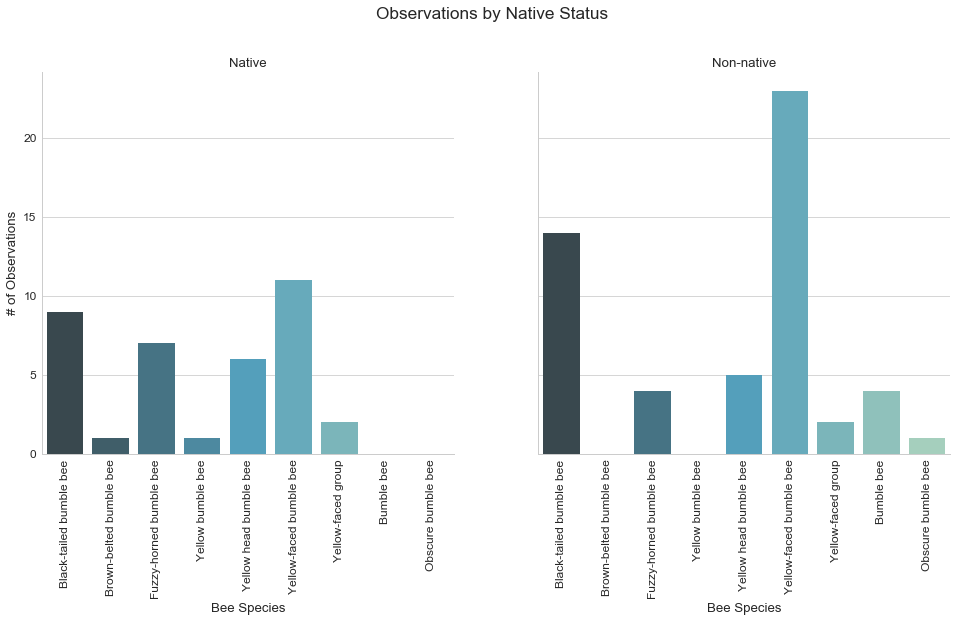

In [121]:
counts_compare = pd.DataFrame(verified_sightings.groupby(['native_status', 'common_name']).size())
counts_compare.columns = ['Count']
counts_compare = counts_compare.reset_index()
g = sns.factorplot(x="common_name", y="Count",
                    col="native_status", kind="bar", size=7, data=counts_compare, palette="GnBu_d")
(g.set_axis_labels("Bee Species", "# of Observations")
    .set_titles("{col_name}")
    .set_xticklabels(rotation=90))
#sns.set_style("whitegrid")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Observations by Native Status")

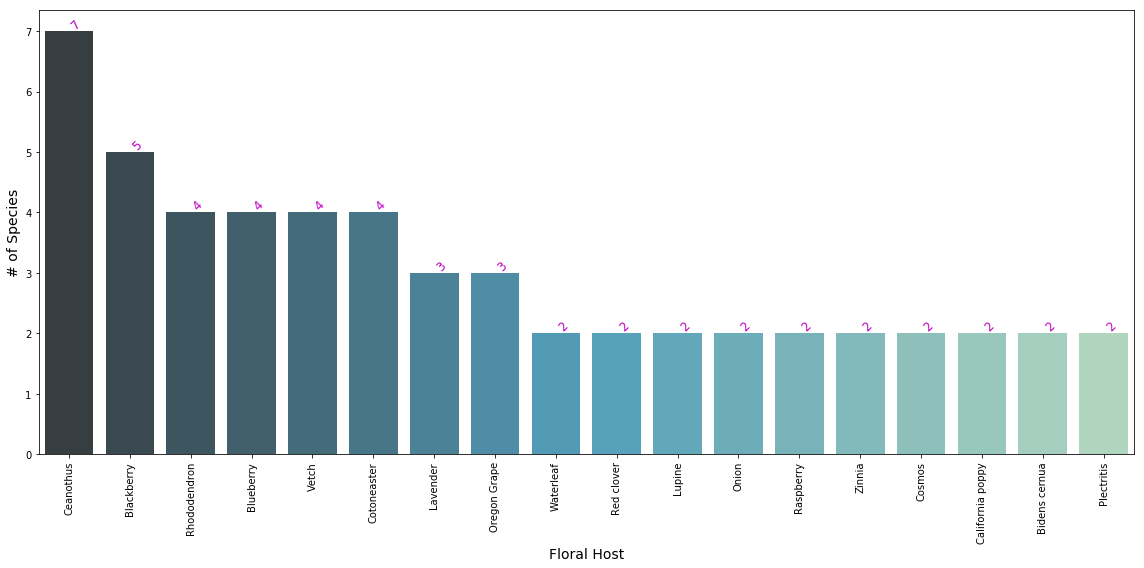

In [8]:
verified_sightings
bee_flower = pd.DataFrame(verified_sightings.groupby(['floral_host', 'common_name']).size())
bee_flower.columns = ['Count']
bee_flower['Count'] = 1
new = pd.DataFrame(bee_flower.groupby(['floral_host']).sum())
new = new[new['Count'] > 1]
new = new.sort_values(['Count'], ascending=False)
result = new.unstack(level=1)
# plot = new.unstack(level=1).plot(kind='bar', subplots=False, figsize=(14,8))
# plot.set_xticklabels(result.index.get_level_values(1))
# plot.set_ylabel('# of different species')
# plot.set_xlabel('Floral Host')

# Create a figure
plt.figure(2, figsize=(16, 8))
# Plot barchart with DataFrame index as x values
ax2 = sns.barplot(result.index.get_level_values(1), result.Count, palette="GnBu_d")
# ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax2.set_xlabel('Floral Host', fontsize=14)
ax2.set_ylabel('# of Species', fontsize=14)
ax2.set_xticklabels(numVisits.index, size=10)
for item in ax2.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(result['Count'].iteritems()):
    ax2.text(i, v[1], '{:,}'.format(v[1]), color='m', va='bottom', rotation=45, size=12)
plt.tight_layout()
plt.show()

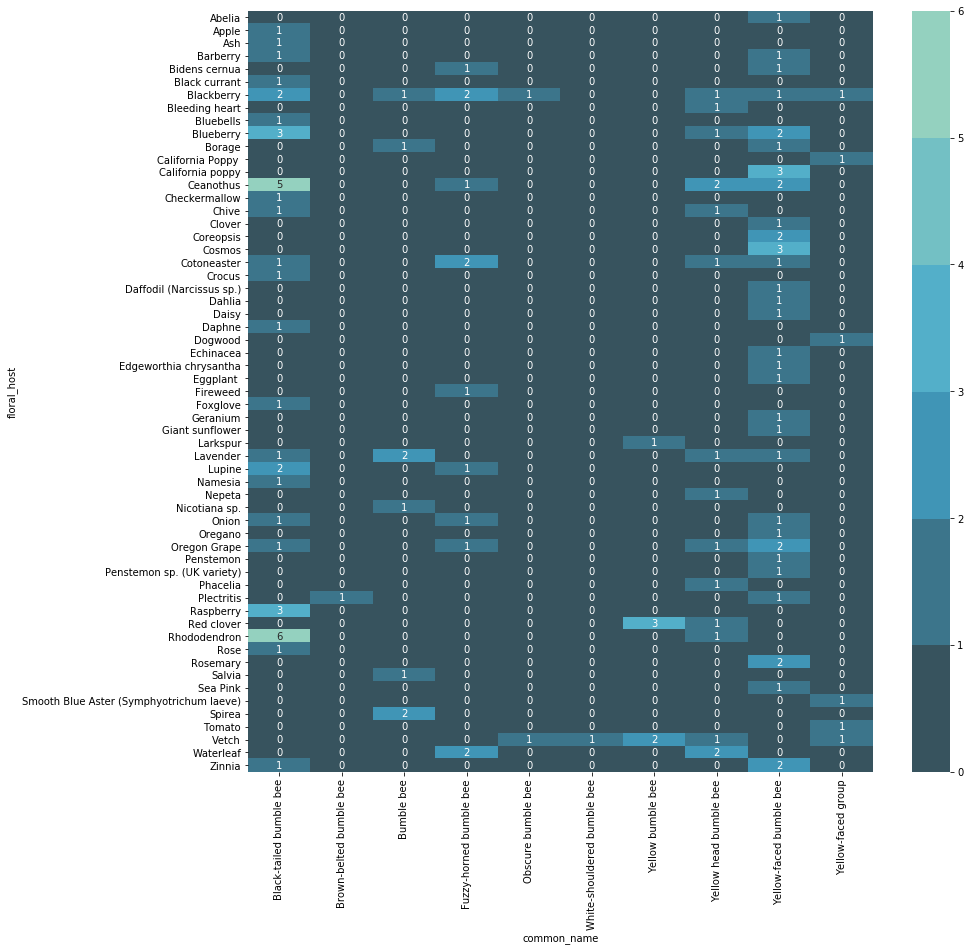

In [36]:
# Heatmap of flower visits by species
heatmap = pd.DataFrame(verified_sightings.groupby(['floral_host', 'common_name']).size())
heatmap.columns = ['count']
heatmap = heatmap.reset_index()
heatmap_pivot = heatmap.pivot("floral_host", "common_name", "count")
heatmap_pivot.fillna(0, inplace=True)
plt.figure(2, figsize=(14,14))

my_cmap = ListedColormap(sns.color_palette("GnBu_d").as_hex())
sns.heatmap(heatmap_pivot, annot=True, cmap=my_cmap) #viridis

In [10]:
"""Generalization ratio (aka standard deviation of visit percentages) including zeros"""

# Calculate the percentage of visits each flower received by species. This normalizes data
sum_by_species = {key: value.sum() for key, value in heatmap_pivot.items()}
percentages_by_species = {}
for key, value in heatmap_pivot.items():
    percentages_by_species[key] = value / sum_by_species[key]
    
# Calculate the standard deviation of those percentages
stdev_by_species = {}
for key, value in percentages_by_species.items():
    stdev_by_species[key] = np.std(value)
print(stdev_by_species)

{'Black-tailed bumble bee': 0.030552263674475839, 'Brown-belted bumble bee': 0.1290809000993883, 'Bumble bee': 0.053765159069701363, 'Fuzzy-horned bumble bee': 0.042794512450686766, 'Obscure bumble bee': 0.09048371400026535, 'White-shouldered bumble bee': 0.12908090009938827, 'Yellow bumble bee': 0.079398131765848562, 'Yellow head bumble bee': 0.032200602020276831, 'Yellow-faced bumble bee': 0.019765938626594242, 'Yellow-faced group': 0.050374447740471777}


In [11]:
stdev_df = pd.Series(stdev_by_species).sort_values(ascending=False)
stdev_df

Brown-belted bumble bee        0.129081
White-shouldered bumble bee    0.129081
Obscure bumble bee             0.090484
Yellow bumble bee              0.079398
Bumble bee                     0.053765
Yellow-faced group             0.050374
Fuzzy-horned bumble bee        0.042795
Yellow head bumble bee         0.032201
Black-tailed bumble bee        0.030552
Yellow-faced bumble bee        0.019766
dtype: float64

In [12]:
#manipulate dataframe so it's bee species by native/non-native

observed = nativeNon.unstack().transpose()
compare = observed.filter(['Black-tailed bumble bee','Yellow-faced bumble bee'], axis=1)
compare
#observed

common_name          Black-tailed bumble bee  Yellow-faced bumble bee
      native_status                                                  
Count Native                             9.0                     11.0
      Non-native                        14.0                     23.0

In [13]:
#http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 1)   # *

print("Critical value")
print(crit)
stats.chi2_contingency(observed= compare)

Critical value
3.84145882069


(0.059124645745489743,
 0.80788486090699263,
 1,
 array([[  8.07017544,  11.92982456],
        [ 14.92982456,  22.07017544]]))

In [14]:
oddsratio, pvalue = stats.fisher_exact(compare)
pvalue

0.77784646022868065

In [15]:
just_rhodies = verified_sightings.loc[verified_sightings['floral_host'] == 'Rhododendron']
just_rhodies

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
196,5141,Black-tailed bumble bee,2015-05-04 00:00:00.000000,45.490740,-122.723165,Rhododendron,2,None
250,1760,Black-tailed bumble bee,2014-05-11 00:00:00.000000,45.473823,-122.530831,Rhododendron,2,None
253,1619,Black-tailed bumble bee,2014-05-10 00:00:00.000000,45.501999,-122.594913,Rhododendron,2,None
259,1473,Black-tailed bumble bee,2014-05-11 00:00:00.000000,45.463636,-122.704898,Rhododendron,2,None
262,1395,Black-tailed bumble bee,2014-05-07 00:00:00.000000,45.498301,-122.601864,Rhododendron,2,None
276,1199,Black-tailed bumble bee,2014-04-29 00:00:00.000000,45.538177,-122.632441,Rhododendron,2,None
305,331,Yellow head bumble bee,2013-05-20 00:00:00.000000,45.473841,-122.530784,Rhododendron,2,None


In [16]:
compare2 = compare.copy()
compare2['Black-tailed bumble bee'][0] = 15
compare2

common_name          Black-tailed bumble bee  Yellow-faced bumble bee
      native_status                                                  
Count Native                            15.0                     11.0
      Non-native                        14.0                     23.0

In [17]:
stats.chi2_contingency(observed= compare2)

(1.6897012963189435,
 0.19364034956681733,
 1,
 array([[ 11.96825397,  14.03174603],
        [ 17.03174603,  19.96825397]]))

In [18]:
oddsratio2, pvalue2 = stats.fisher_exact(compare2)
pvalue2

0.13355620326612139

In [19]:
# Estimating probability a flower is native, given I see each species

# P(Native) = 20/57 = 35%
# P(Non-native) = 1 - 0.35 = 65%
# P(Black|Native) = 9/20  = 45%
# P(Yellow|Native) = 1 - 0.45 = 55%
# P(Black|Non-native) = 14/37 = 38%
# P(Yellow|Non-native) = 1 - 0.38 = 62%

# P(Black) = P(Native) * P(Black|Native) + P(Non-native) * P(Black|Non-native)
#          = 0.35 * 0.45 + 0.65 * 0.38 = 40.45%
# P(Yellow) = 59.55%

# P(Native|Black) = (P(Native) * P(Black|Native)) / P(Black)
#                 = 0.35 * 0.45 / 0.4045 = 38.9%
# P(Native|Yellow) = (P(Native) * P(Yellow|Native)) / P(Yellow)
#                  = 0.35 * 0.55 / 0.5955 = 32.3%

# Choosing a flowering plant/shrub at random, there's a 35% chance it's native. Seeing a Black-tailed bumblebee slightly
# slightly increases the chances, to almost 39%, whereas observing a Yellow-Faced bumblebee drops the probability it is a native
# plant to around 32%. 


In [20]:
# Total Native plant observations
len(verified_sightings.loc[verified_sightings['native_status'] == 'Native'])

37

In [21]:
# Total non-native plant observations
len(verified_sightings.loc[verified_sightings['native_status'] == 'Non-native'])

53

In [22]:
11/28

0.39285714285714285